# Workshop: Building complex systems can be easy!

In this workshop we will build upon the work done in the previous session by creating a more complex system using code from the prior workshop. This session, while still remaining simple and linear, will demonstrate that complex systems are easy to implement if you are able to correctly decompose the problem into simple building blocks. 

This tutorial should take up to 2 hours to complete.

Please read through each section carefully and complete each code block in order. Code that you're required to complete will be discussed in the text and marked with the following comment with the code blocks:

`#TODO: ...`

## 0. Recap

Last session we walked through a paper and looked to implement written theory into a practical implementation within Python. 

## 1. Python Introduction

As with the previous workshop, a basic understanding of programming concepts is assumed for this workshop. For a general refresher on Python and its syntax, follow this link: 
https://www.w3schools.com/python/

Within this tutorial we will be using the following basic concepts:

1. Dictionaries
2. Classes
3. Functions / Methods
4. numpy

## 2. Neuron Implementation

Below is an implementation of the simple LIF neuron from the last workshop. The data and functionality has been encapsulated within a class. Don't worry too much about how this is done, all that matters is that by writing our implementation in this manner, we are able to easily reuse and copy this neuron. 

In [1]:
class LIFNeuron():
    def __init__(self, **kwargs):
        self.v_thresh = kwargs.get("v_thresh", -50e-3)
        self.v_reset = kwargs.get("v_reset", -70e-3)
        self.tau = kwargs.get("tau", 20e-3)
        self.E_leak = kwargs.get("E_leak", -60e-3) 
        self.r = kwargs.get("r", 100e6)
        self.v = self.v_reset
        
    def run_spk(self, dt, i):
        # Calculate membrane potential and leakage
        self.v = self.v + (dt / self.tau * (self.E_leak - self.v + (self.r*i)))
                
        # Check if the membrane potential has exceeded the threshold
        if self.v > self.v_thresh:
            self.v = self.v_reset
            return 1
        else:
            return 0

Let's test this new implementation in the same basic simulation as we did in our previous workshop and plot the results. This simulation will loop for 50 timesteps and apply a constant current to the LIF neuron.


Once you've ran the simulation below, make the following changes to the simulation and observe the results:

1. Adjust the code so that there's 100 timesteps in the simulation
2. Based on your knowledge from the previous workshop, adjust the neuron parameters such that the neuron spike rate increases
3. Adjust the simulation to record the membrane potential of the neuron at each timestep

**NOTE:** Make each of the changes in order so that you can observe the results of each change independently.

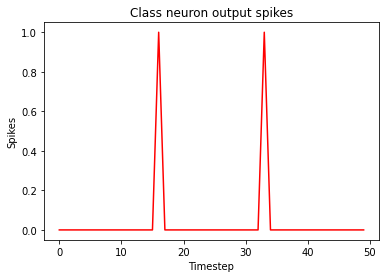

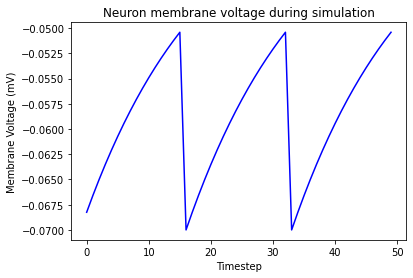

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Simulation parameters
timesteps = 50   # We simulate over 50 timesteps (50ms)
i = 25e-11       # Constant current of 250nA
dt = 1e-3        # Each timestep is 1ms
s_list = []      # This list will contain our spike outputs
v_list = []      # This list will contain our neuron voltages 

# Neuron parameters
neuron_params = {
    "v_thresh": -50e-3,
    "v_reset": -70e-3,
    "tau": 20e-3,
    "E_leak": -60e-3,
    "r": 100e6
}

# Create an instance of our neuron class using our defined neuron parameters
LIF = LIFNeuron(**neuron_params)

# This loop will run our simulation for the number of timesteps specified above
for time in range(timesteps):

    # Run our neuron spike function. It will return 1 or 0 to show if a spike has or has not occured
    s = LIF.run_spk(dt, i) 

    # Record the output spikes using a list
    s_list.append(s)
    v_list.append(LIF.v)

    
# Plot the data collected in our s_list
plt.plot(np.arange(len(s_list)), s_list, color="red")
plt.xlabel("Timestep")
plt.ylabel("Spikes")
plt.title("Class neuron output spikes")
plt.show()
plt.clf()
plt.plot(np.arange(len(v_list)), v_list, color="blue")
plt.xlabel("Timestep")
plt.ylabel("Membrane Voltage (mV)")
plt.title("Neuron membrane voltage during simulation")
plt.show()

As we can see from the above plot, the operation of this neuron is identical to the results of our previous simulation. Now that we have verified the operation of a single LIF neuron, lets expand this simulation by simulating multiple neurons at once.

In this example, our second LIF neuron will recieve a sinusoidal input current so that we can see a difference in our output plot.

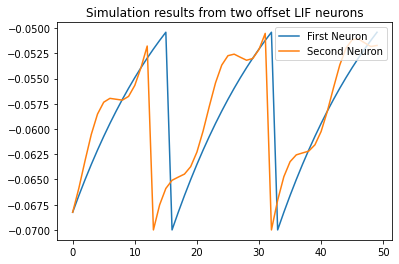

In [3]:
# Simulation parameters
timesteps = 50   # We simulate over 50 timesteps (50ms)
i_mean = 25e-11       # Constant current of 250nA
dt = 1e-3        # Each timestep is 1ms
s1_list = []     # This list will contain our simulation outputs from our first LIF neuron
s2_list = []     # This list will contain our simulation outputs from our second LIF neuron
    
# Neuron parameters contained in a dictionary
neuron_params = {
    "v_thresh": -50e-3,
    "v_reset": -70e-3,
    "tau": 20e-3,
    "E_leak": -60e-3,
    "r": 100e6
}
    
# Create an instance of our neuron class using our defined neuron parameters
first_LIF = LIFNeuron(**neuron_params)
second_LIF = LIFNeuron(**neuron_params)

# This loop will run our simulation for the number of timesteps specified above
for time in range(timesteps):
    
    # Find the time at this timestep
    t = time * dt
    
    # Calculate the discrete sinusoidal current at this timestep 
    i_sin = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))
    
    # Run our neuron spike function. It will return 1 or 0 to show if a spike has or has not occured
    s1 = first_LIF.run_spk(dt, i_mean) 
    s2 = second_LIF.run_spk(dt, i_sin)
    
    # Track the output spikes using a list
    s1_list.append(first_LIF.v)
    s2_list.append(second_LIF.v)
    
# Plotting the output spikes of both neurons
plt.plot(np.arange(len(s1_list)), s1_list, label="First Neuron")
plt.plot(np.arange(len(s2_list)), s2_list, label="Second Neuron")
plt.title("Simulation results from two offset LIF neurons")
plt.legend(loc=1)
plt.show()

As shown in the plot above, by encapsulating our data within a class, we are able to create two completely independent neurons that are both using the same code. Now we can start connecting these neurons together to form a basic neural network.

## 3. Simple Spiking Neural Networks (SNNs)

The further our understanding of SNNs let's briefly discuss an abstracted network. Below is a diagram showing a network of interconnected nodes.

![alt text](SNN_Diagram.png)

Each of these nodes is attached to each other node in the subsequent layer. Each of the nodes present in this diagram can be seen as an LIF neuron like the one we implemented above. Information passed forward by each node is therefore presented as an input to the following nodes via this simple formula: 

\begin{equation}
input_{n} = \sum\limits_{n=1}^N w_{n}x_{n}
\end{equation}

Where $n$ is the selected neuron, $N$ is the total number of neurons in the prior layer, $w$ is the weight of a given connection and $x$ is the output from the prior neuron along said connection.

In terms of current and voltage, we assume in this workshop that the incoming input into a neuron follows the following equation.

\begin{equation}
V_{in_{n}} = \left\{\begin{matrix}
    0 & No \: spike\\ 
    I * w_{n} & Spike
    \end{matrix}\right.
\end{equation}

From this simple equation we can see that the input to our LIF neurons are now dependent on the output of previous neurons along a chain of weighted connections. When a neuron spikes within this network, it elicits a synaptic current for a single timestep. This current is similar to the constant current example we have used previously. This current is modified by the weight of the connection between the spiking neuron and the reciving neuron. When training networks, we seek to increases the strength of connections between two related neurons, while reducing the strength of connections between unrelated neurons. This may seem very confusing but don't worry too much about how to train these networks at the moment, as during this workshop we will be making changes to our weights by hand.

In order to begin building these networks we must first initialise a vector of LIF neurons to represent our input layer.

**NOTE**: The steps taken to build these networks within this section as NOT the most efficient way to build SNNs in Python, but require minimal external libraries and additional abstractions.

In [4]:
# Network parameters
input_size = 10

# Initialise an empty vector with the correct input layer size
input_layer = np.empty(input_size, dtype=object)

# Instatiate an LIF neuron for each element in the input vector
for element in range(input_size):
    input_layer[element] = LIFNeuron(**neuron_params)

Now that we have initialised our networks input layer, lets apply current to each neuron. In the block below we will apply a sinusoidal input to each neuron.

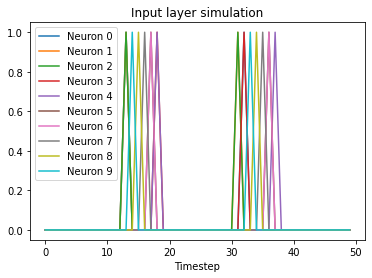

In [5]:
# Simulation parameters
timesteps = 50   # We simulate over 50 timesteps (50ms)
i_mean = 25e-11       # Constant current of 250nA
dt = 1e-3        # Each timestep is 1ms

# TODO: Create an output array that contains the output of each neuron at each timestep
# outputs = ?
outputs = np.zeros((input_size, timesteps))  # REMOVE

# TODO: Create a vector that contains the time at each timestep
# t = ?
t = np.arange(0, (timesteps*dt) + (input_size*dt), dt)

# Using this t array we can calculate each step of the input current sin wave
i_sin = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))

# This loop will run our simulation for the number of timesteps specified above
for time in range(timesteps):
    # To get an output from each of our neurons, we must also iterate over our input layer every timestep
    for n in range(input_size):
        # In order to graph the output spikes of our network in a visible way - we require the current to be slightly out of phase for each neuron
        # NOTE: This is purely for demonstration within this block of code and shouldn't be used again
        i = i_sin[time+n]
        
        # TODO: Collect the results from this neuron at this timestep
#         outputs = ?
        outputs[n][time] = input_layer[n].run_spk(dt, i)


# Plot the output from each neuron
for idx, output in enumerate(outputs):
    plt.plot(np.arange(timesteps), output, label=f"Neuron {idx}")
    
plt.title("Input layer simulation")
plt.xlabel("Timestep")
plt.legend()
plt.show()

We have just successfully simulated the first layer of a SNN that we've built from scratch! This system we've created is simple but it demonstrates how complex problems can be easily decomposed and implemented in different steps. 

Next, initialise a second layer to add to our simulation. Use the code above as a reference.

In [6]:
l1_size = 10 # Size of layer 1

# TODO: Initialise a vector of LIF neuron objects. Refer to the code above for creating a vector of LIF objects
# l1 = ?
l1 = np.empty(l1_size, dtype=object)   # REMOVE

# TODO: Instatiate an LIF neuron for each element in the input vector
# for element in ?:
    
for element in range(l1_size):   # REMOVE
    l1[element] = LIFNeuron(**neuron_params)   # REMOVE

The two layers we've created this far will be densely connected together. This simply means that each neuron in each layer is connected to each neuron in the next layer. Now that we have two layers initialised we will create an array of weights that govern the strength of all the connections that must be made. To do this we shall create a 2d array of random values between 0 and 1. The size of this weight array should be $input\_size * l1\_size$ due to the dense connections. 

For the code section below, use the np.rand.random() function to create our weights array. Documentation found here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html

In [7]:
# TODO: Create a 2d array of random weights 
# w1 = ?
w1 = np.random.rand(input_size, l1_size)

# Print out the weights matrix to confirm that the values are between 0 and 1
print(w1)

[[0.88000347 0.05131535 0.6238317  0.18204496 0.19099438 0.46278936
  0.4679743  0.38837182 0.49597984 0.86639907]
 [0.00830438 0.7513313  0.51291213 0.05349219 0.63927876 0.02116271
  0.18469267 0.81475736 0.43540779 0.4541429 ]
 [0.71338516 0.96074225 0.38911807 0.22284215 0.29448455 0.76062992
  0.71655886 0.94217318 0.27632917 0.61495436]
 [0.30461264 0.65280236 0.90090563 0.72902859 0.7910679  0.13284966
  0.03301457 0.09234407 0.93455816 0.73284792]
 [0.14855021 0.79932149 0.50694428 0.43149036 0.1771546  0.23201867
  0.47627755 0.78815996 0.38658569 0.79816817]
 [0.08364352 0.35287479 0.59905422 0.09521711 0.64456852 0.14764274
  0.83786691 0.80130999 0.8204189  0.42435495]
 [0.00607368 0.30949626 0.60617768 0.83904073 0.11687772 0.7863455
  0.73924722 0.33315075 0.3047592  0.01317095]
 [0.09243534 0.3797591  0.37313227 0.14751233 0.52054842 0.39515216
  0.07834004 0.52732966 0.30378706 0.01811324]
 [0.55465044 0.82626163 0.16088127 0.33144341 0.67327398 0.25159346
  0.13146865 

We now have the three components needed for our simple, two layer network. We have initialised both layers and the matrix of weights that governs their connections.

We're now ready to simulate our simple network. Below you should write the code to run a simulation with the following parameters:

\begin{equation}
timesteps: 150\\
dt: 1e-3\\
i: 25e-11\\
\end{equation}

The input current will be constant in this simulation.

Below I've provided a function for you to use. This function will calculate the current provided to a layer of neurons given the spike current, weight matrix and the input spike vector it's set to recieve. Use this within your simulation. There's a doc string provided to help you understand the inputs and outputs from the function.

**NOTE**: This can be a challenging task if you're not very familiar with Python. Don't hesitate to ask the instructors for guidance if you're struggling to complete the task.

In [8]:
def calculate_current(spike_current, in_vector, out_size, weights):
    """
    Function to calculate the input curre
    
    Arguments:
    
    spike_current (float): The input current for the simulation
    in_vector (numpy array): Vector of input spikes (0 or 1) taken from the preivous layer 
    out_size (int): The number of neurons in the next layer
    weights (numpy array): The weight matrix connecting the input to the output layer
    
    Returns:
    
    i (numpy array): Vector of input currents to the next layer of neurons
    """
    
    # Previous layer output multiplied with spike current gives current output from each of the prior neurons
    currents = in_vector * spike_current
    
    # Multiply currents with weighted connections
    currents = np.repeat(currents, out_size, axis=0).reshape((in_vector.shape[-1], out_size))
    layer_input = currents * weights
    
    # Sum all of the incoming currents into each neuron
    i = np.sum(layer_input, axis=1)
    
    # Return a vector of input currents
    return i

In [9]:
# TODO: Set your simulation params
# timesteps = ?
# dt = ?
# i = ?
timesteps = 150   # REMOVE
dt = 1e-3         # REMOVE
i = 25e-11        # REMOVE

# Input spike array - we're applying an input spike to each neuron at each timestep
input_spikes = np.ones(input_size)

# TODO: Create arrays to contain outputs from each layer (HINT: Think about the shape of these arrays, they should contain information on each neuron at each timestep)
# input_out = np.empty((input_size, ?))
# l1_out = np.empty((l1_size, ?))
input_out = np.empty((input_size, timesteps))   # REMOVE
l1_out = np.empty((l1_size, timesteps))         # REMOVE

# TODO: Run simulation for a set number of timesteps
# for time in range(?):
for time in range(timesteps):   # REMOVE
    # Create array containing output vector from each layer. NOTE: The layers are of the same size here
    out = np.empty(input_size)
    
    # Take the input spikes and multiply by DC input current to get input current
    input_currents = input_spikes * i
    
    # Take input and apply spike function 
    for neuron in range(input_size):
        # Get output from the input layer
        s = input_layer[neuron].run_spk(dt, input_currents[neuron])
        out[neuron] = s
        
        # Record output of input layer for plotting
        input_out[neuron][time] = s
    
    # TODO: Calculate input currents to next layer (HINT: You can use the function provided above)
#     l1_currents = ?
    l1_currents = calculate_current(i, out, l1_size, w1)    # REMOVE
        
    # Apply calculated current and spike function to next layer
    for neuron in range(l1_size):
        #  TODO: Get output from the next layer
#         s = l1[neuron].run_spk(dt, ?)
        s = l1[neuron].run_spk(dt, l1_currents[neuron])  # REMOVE
        
        # TODO: Record output from final layer
#         l1_out?
        l1_out[neuron][time] = s   # REMOVE

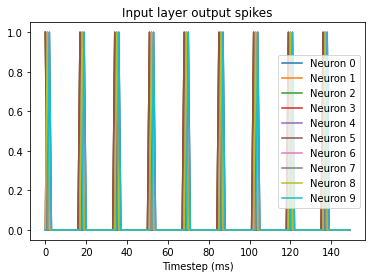

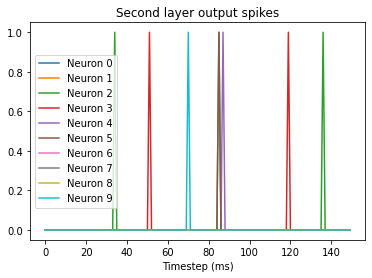

In [10]:
# Plot the output from each neuron
for idx, output in enumerate(input_out):
    plt.plot(np.arange(timesteps), output, label=f"Neuron {idx}")
    
plt.legend()
plt.title("Input layer output spikes")
plt.xlabel("Timestep (ms)")
plt.show()

# Plot the output from each neuron
for idx, output in enumerate(l1_out):
    plt.plot(np.arange(timesteps), output, label=f"Neuron {idx}")
    
plt.legend()
plt.title("Second layer output spikes")
plt.xlabel("Timestep (ms)")
plt.show()

You have now sucessfully created a SNN! Congratulations! Now let's change some of our paramters to elicit different behaviour within our simulation. You should see from the above plots that the neurons in the input layer are spiking very uniformly, whereas the spikes from the second layer are more sporadic. This is due to our randomly initialised weight matrix. By changing this matrix, we can change the spiking patterns we observe at our output.

Try some of the following changes to your network/simulation. Hypothesise to yourself or within your groups about how these changes will affect the simulation. Make these changes one at a time and observe the results, do they elicit the behaviour your hypothesised?:

1. Change your weight array such that only "Neuron 0" in the second layer output spikes during this simulation.
2. Adapt the simulation such that the current into the input layer is sinusoidal. 
3. Adapt the simulation such that the membrane voltage of each neuron is plotted, rather than their output spikes
4. Change the `input_spikes` array to see the effects of different input spiking patterns

Once you have made those changes and observed the effects, complete the code block below. This block looks at the changing voltage levels in each of your layers. Once the block is running correctly, make changes to the `neuron_params` dictionary and observe the effects.

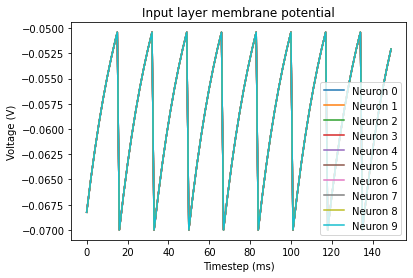

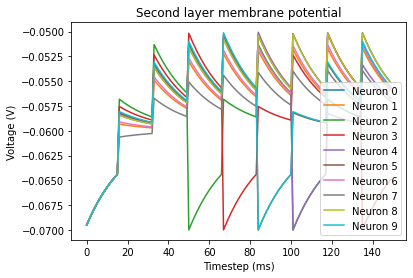

In [13]:
# Neuron parameters
# TODO: Adjust these parameters in order to observe the effects on the plots below
neuron_params = {
    "v_thresh": -50e-3,
    "v_reset": -70e-3,
    "tau": 20e-3,
    "E_leak": -60e-3,
    "r": 100e6
}

# Create an instance of our neuron class using our defined neuron parameters
LIF = LIFNeuron(**neuron_params)

# Instatiate an LIF neuron for each element in the input and l1 vectors
for element in range(input_size):
    input_layer[element] = LIFNeuron(**neuron_params)
    l1[element] = LIFNeuron(**neuron_params)

    
# Simulation params
timesteps = 150
dt = 1e-3
i = 25e-11

# Input spike array
input_spikes = np.ones(input_size)

# TODO: Create arrays containing outputs from each 
# input_v = ?
# l1_v = ?
input_v = np.empty((input_size,timesteps))    # REMOVE
l1_v = np.empty((l1_size,timesteps))          # REMOVE

for time in range(timesteps):
    # Create array containing output vector from each layer. NOTE: The layers are of the same size here
    out = np.empty(input_size)
    
    # Take the input spikes and multiply by DC input current to get input current
    input_currents = input_spikes * i
    
    # Take input and apply spike function 
    for neuron in range(input_size):
        # Get output from the input layer
        s = input_layer[neuron].run_spk(dt, input_currents[neuron])
        out[neuron] = s
        
        # Record output of input layer for plotting
        input_v[neuron][time] = input_layer[neuron].v
    
    # TODO: Calculate input currents to next layer
#     l1_currents = ?
    l1_currents = calculate_current(i, out, l1_size, w1)   # REMOVE
        
    # Apply current and spike function to next layer
    for neuron in range(l1_size):
        #  Get output from the next layer
        s = l1[neuron].run_spk(dt, l1_currents[neuron])
        
        # Record output from final layer
#         l1_v?
        l1_v[neuron][time] = l1[neuron].v     # REMOVE
        
        
# Plot the output from each neuron
for idx, output in enumerate(input_out):
    plt.plot(np.arange(timesteps), input_v[idx], label=f"Neuron {idx}")
    
plt.legend()
plt.title("Input layer membrane potential")
plt.xlabel("Timestep (ms)")
plt.ylabel("Voltage (V)")
plt.show()

# Plot the output from each neuron
for idx, output in enumerate(l1_out):
    plt.plot(np.arange(timesteps), l1_v[idx], label=f"Neuron {idx}")
    
plt.legend()
plt.ylabel("Voltage (V)")
plt.title("Second layer membrane potential")
plt.xlabel("Timestep (ms)")
plt.show()

# 4. Recap

Within this workshop we have implemented a very rudamentary spiking neural network. We have changed both system and simulation varialbes in order to elicit different behaviours from our networks. We have achieved this by building simple building blocks of reusable code. Within a real application we would usually utilise pre-written software libraries to create these networks. However, it is always important to understand the basics of any techniques you're using during your research.

The use of spiking neural networks is a large ongoing research area, especially as it relates to their use within  robotic systems. Training these networks by adjusting their weight matrices and neuron parameters is a difficult task but has the potential to produce very efficient networks capable of complex behaviours such as interpretting sensor data and navigation.